# 1. Introduction

Name: Wahyudi

Objective: Create a Consumer Segmentation Model

I am imagining that a company is consulting me about its problem. This company will hold an event this weekend. At this event, consumers will get various kinds of programs and promotions according to their segmentation. The problem started when the marketing team responsible for segmentation was on holiday to **Africa** and couldn't be contacted until the event started. This employee has not had time to explain how to segment and what the characteristics of each segment are. Even though the character of each segment is important for companies to be able to provide the right programs and promotions.

The company asked me to segment and research its consumers. The segmentation data will be used to make decisions about the appropriate treatment for each segment.

This is a research document that I carried out. Application of research results open [here](https://clustering-customer-hacktive8.herokuapp.com/cluster_csv). Use `example.csv` to try.

# 2. Import Libraries

Import everything needed for research.

In [2]:
# Import Libraries
import math
import warnings
import pandas as pd
import numpy as np
import wahyu_lib
from pandas.core.common import SettingWithCopyWarning
import pickle

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer



from clusteval import clusteval
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, DBSCAN
from sklearn.pipeline import Pipeline
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [3]:
# ignore warning pandas
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# 3. Data Loading

In [4]:
#load dataset 
data=pd.read_csv('marketing_campaign.csv', sep="\t")
data

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduation,Married,61223.0,0,1,13-06-2013,46,709,...,5,0,0,0,0,0,0,3,11,0
2236,4001,1946,PhD,Together,64014.0,2,1,10-06-2014,56,406,...,7,0,0,0,1,0,0,3,11,0
2237,7270,1981,Graduation,Divorced,56981.0,0,0,25-01-2014,91,908,...,6,0,1,0,0,0,0,3,11,0
2238,8235,1956,Master,Together,69245.0,0,1,24-01-2014,8,428,...,3,0,0,0,0,0,0,3,11,0


The data contains 2240rows and 29 columns.

I changed the `yearbirth` data to `age`. Because age will be easier to understand compared to birth year data. For example, a computer will more easily recognize a 10 year old child who is 2x older than a 5 year old child. If the data is the year of birth, it will be difficult for the computer to say that a child born in '2004' is 2x older than a child born in '2019' because the computer will focus on the number.

In [5]:
data['age']=2014-data.Year_Birth
data.drop(columns='Year_Birth', inplace=True)

Just like the date of birth of the Dt Customer feature, I changed it to how long the consumer has been a customer. I changed the data which was originally the date the consumer was registered as a consumer to become the number of days since the consumer was registered as a consumer until the last time this data was taken. I assume that the last time the data was collected is the same as the most recent date the consumer was registered.

In [6]:
data.Dt_Customer=pd.to_datetime(data.Dt_Customer, dayfirst=True)
terakhir=data["Dt_Customer"].max()
data['Dt_Customer']=terakhir-data["Dt_Customer"]
data['Dt_Customer']=data.Dt_Customer.astype('timedelta64[D]')


Because 2n Cycle and Master have the same level, it was decided that `2n cycle` should also be written as `Master`

In [7]:
# Replaca 2n cycle with master
data['Education'].replace(['2n Cycle'],'Master', inplace=True)

In [8]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,2240.0,5592.159821,3246.662198,0.0,2828.25,5458.5,8427.75,11191.0
Income,2216.0,52247.251354,25173.076661,1730.0,35303.00,51381.5,68522.00,666666.0
Kidhome,2240.0,0.444196,0.538398,0.0,0.00,0.0,1.00,2.0
Teenhome,2240.0,0.506250,0.544538,0.0,0.00,0.0,1.00,2.0
Dt_Customer,2240.0,353.582143,202.122512,0.0,180.75,355.5,529.00,699.0
Recency,2240.0,49.109375,28.962453,0.0,24.00,49.0,74.00,99.0
MntWines,2240.0,303.935714,336.597393,0.0,23.75,173.5,504.25,1493.0
MntFruits,2240.0,26.302232,39.773434,0.0,1.00,8.0,33.00,199.0
MntMeatProducts,2240.0,166.950000,225.715373,0.0,16.00,67.0,232.00,1725.0
MntFishProducts,2240.0,37.525446,54.628979,0.0,3.00,12.0,50.00,259.0


There are 2 features that have standard deviation = `0`. A feature that has a standard deviation of 0 means the data has a unique value of only 1 because it has perfect diversity. Data with perfect diversity like this does not carry meaningful information. So I decided to delete the column.

In [9]:
data.drop(columns=['Z_Revenue', 'Z_CostContact'], inplace=True)

# Exploratory Data Analysis

In [10]:
data_eda=data

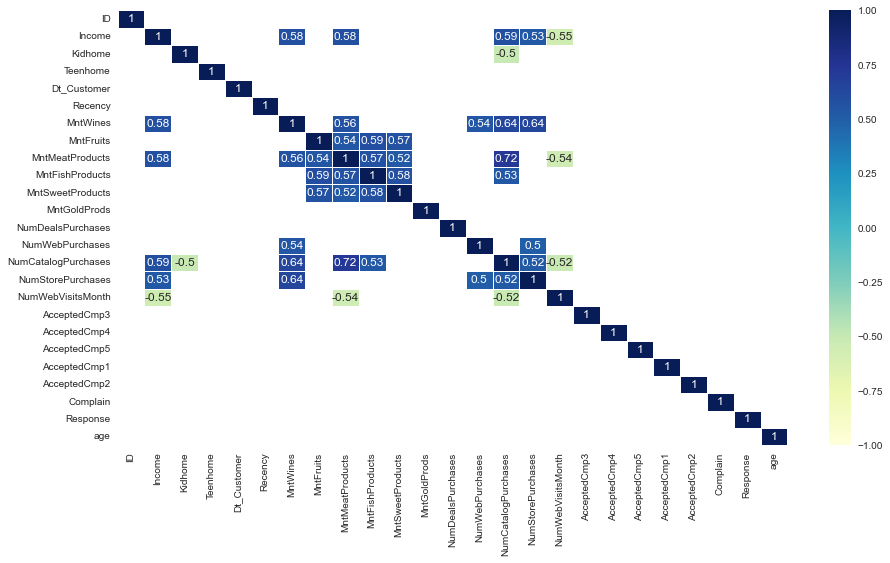

In [11]:
corr = data_eda.corr()
plt.figure(figsize = (15,8))
sns.heatmap(data = corr[(corr>0.5) | (corr<-0.5)], annot = True, vmin=-1, vmax=1, cmap="YlGnBu", linewidths=.5)
plt.show()

`Income` is the feature that has the most impact on other features. It can be seen in the heatmap above that `income` has a high correlation with 5 other features. 4 of them have a positive correlation and 1 feature has a negative correlation with `income`. the `mntwines` and `mint meat` features have a positive correlation with the `income` feature. This means that the greater a person's income, the greater his purchase of meat and wine. This may be to fulfill his needs for serving his guests. Of course, people with high incomes will treat their guests with expensive dishes or perhaps just for their daily needs.

The higher a consumer's income also increases the possibility of increasing their purchases through coming to stores and catalogs. different from the previous 4 features. the `num web visits` feature has a negative correlation. This means that the greater a person's income, the less often that person views the company's website. With the data above, I suggest to companies to sell more of the needs of customers with large incomes such as wine and meat through catalogues.

The highest correlation in the heatmap is the correlation of the `min meat product` feature with the number of catalog purchases. This means that most meat is sold through catalogues. Marketing can use this data as a basis for increasing catalogs and improving the quality of existing catalogs to increase meat sales. As additional information, meat is also suitable to be offered to consumers who have large incomes.

*By increasing the number of consumers who buy meat, marketing may also indirectly increase sales of wines because the two have a high positive correlation value.*

**Marital status**

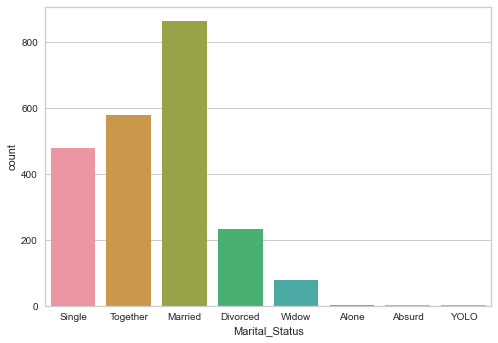

In [12]:
sns.countplot(data=data_eda, x='Marital_Status');

Most of the company's customers are married customers. I want to see what the characteristics of customers who are in a marriage relationship are and those who are not. For that we need to add 1 married column.

**Karakterisitik Pelanggan Berdasarkan Status Pernikahan**

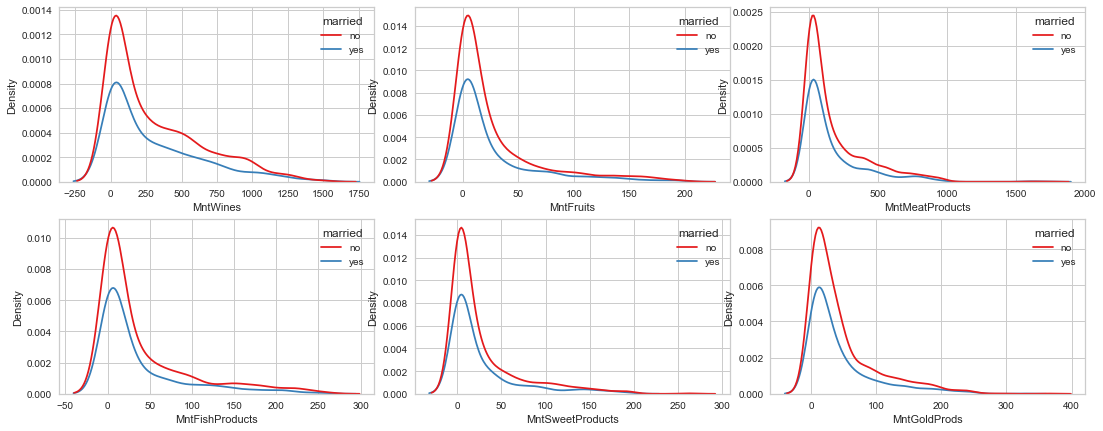

In [13]:
data_eda['married']=np.where(data_eda['Marital_Status']=='Married', 'yes', 'no')
produk=['MntWines', 'MntFruits', 'MntMeatProducts','MntFishProducts', 'MntSweetProducts', 'MntGoldProds',]
wahyu_lib.show_kde(data=data_eda, hue='married', list=produk)

Customers who are in a married relationship or who are not in a married relationship do not have special purchasing characteristics. This can be concluded from the same kde density pattern in all types of products.

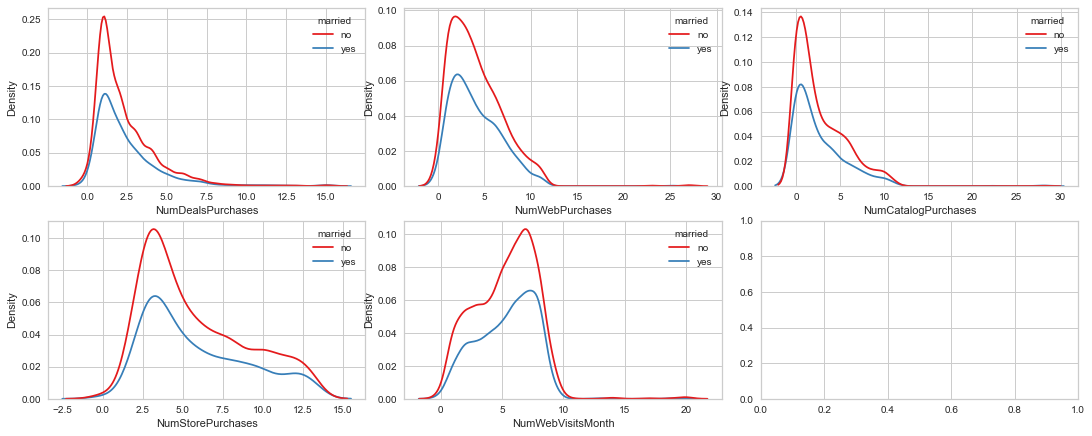

In [199]:
purchase=['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases','NumStorePurchases', 'NumWebVisitsMonth']
wahyu_lib.show_kde(data=data_eda, hue='married', list=purchase)


It's the same with products. Married and unmarried customers do not have special characteristics in choosing a purchasing platform.

In [200]:
data.drop(columns='married', inplace=True)

**Consumer Education**

In [201]:
# Show presentase cust. edu
Education = data_eda.groupby('Education').agg({'Education': 'count'}).rename(columns = {'Education': 'count'}).reset_index()
fig = px.pie(Education, values = Education['count'], names = Education['Education'])
fig.update_traces(textposition = 'inside', 
                  textinfo = 'percent + label', 
                  hole = 0.7, 
                  marker = dict(colors = ['#2A3132','#336B87'], line = dict(color = 'white', width = 2)))

fig.update_layout(title_text = 'Cust. Education', title_x = 0.5, title_y = 0.53, title_font_size = 32, title_font_family = 'Calibri', title_font_color = 'black',
                  showlegend = False)

Most of our customers are customers with graduate education. Companies can carry out promotions and sell more goods that are usually needed by customers with graduation education

**Customer Age**

<AxesSubplot:xlabel='age', ylabel='Count'>

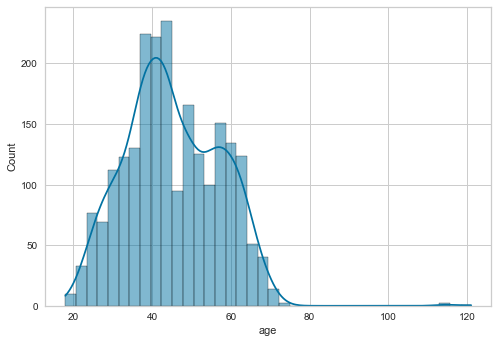

In [16]:
sns.histplot(data=data_eda, x='age', kde=True)

Most of the customers at this company are 40 years old. Companies can add products needed by people over the age of 40 in the front window.

**Customer Revenue**

<AxesSubplot:xlabel='Income', ylabel='Count'>

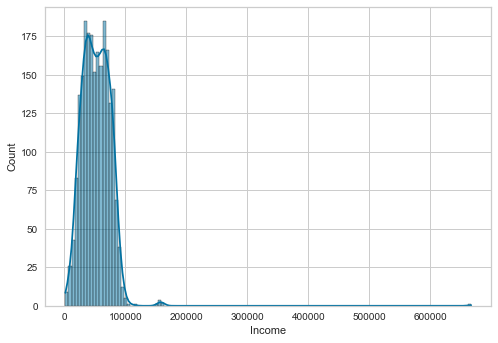

In [19]:
sns.histplot(data=data_eda, x='Income', kde=True)

Most customers are customers who have an income in the range of 300-700 dollars.

**Best Selling Products**

c:\Users\wahyu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


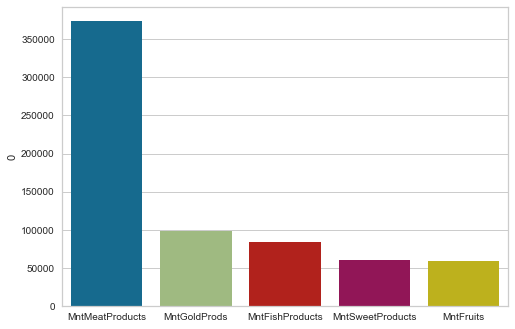

In [31]:
produk=data[['MntFruits', 'MntMeatProducts','MntFishProducts', 'MntSweetProducts', 'MntGoldProds',]].sum().sort_values(ascending=False).to_frame()
sns.barplot(produk.index, produk[0]);

The product most purchased by consumers is meat. I suggest that companies maintain meat stocks so that their stocks don't empty easily and make customers disappointed. 

**The Strongest Platform**

c:\Users\wahyu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


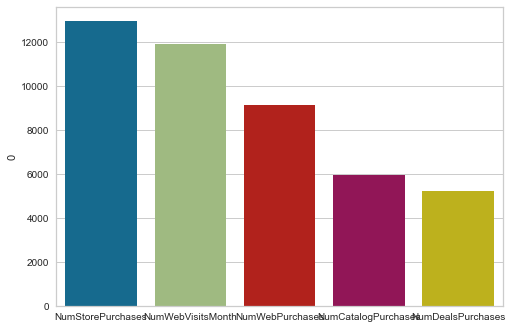

In [32]:
platform=data[['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases','NumStorePurchases', 'NumWebVisitsMonth']].sum().sort_values(ascending=False).to_frame()
sns.barplot(platform.index, platform[0]);

The platform most used by customers is coming directly to the store and purchasing via the website. Service in the shop needs to be maintained well so that most consumers are satisfied shopping at the shop. Apart from that, website performance also needs to be improved so that sales through the website can continue to increase. With current advances in information technology, it is not impossible that there will be more sales through websites than through shops.

# Data Pre Processing

## Get Data Inference

In [202]:
# separating data for inference
data_inf = data.sample(100, random_state=0)
data_train= data.drop(data_inf.index)

In [203]:
data_inf

,ID,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,age
670,9153,PhD,Married,59304.0,0,1,335.0,81,418,61,...,10,5,0,0,0,0,0,0,0,50
570,6818,Graduation,Married,44989.0,0,1,655.0,26,98,0,...,5,6,0,0,0,0,0,0,0,40
39,2968,PhD,Divorced,48948.0,0,0,513.0,53,437,8,...,5,6,1,0,0,0,0,0,1,71
1909,5623,Master,Married,31535.0,1,0,276.0,95,15,4,...,2,7,1,0,0,0,0,0,0,34
2231,9817,Master,Single,44802.0,0,0,677.0,71,853,10,...,12,8,0,0,0,0,0,0,0,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579,5253,Master,Together,54603.0,1,1,355.0,85,145,13,...,4,7,0,0,0,0,0,0,0,58
98,4646,Master,Married,78497.0,0,0,210.0,44,207,26,...,12,2,0,0,0,1,0,0,0,63
2026,4198,Graduation,Together,29672.0,1,1,474.0,6,9,1,...,3,6,0,0,0,0,0,0,0,49
1743,10814,Graduation,Together,70321.0,0,0,529.0,6,303,23,...,13,4,0,0,0,0,0,0,1,67


In [204]:
data_train.drop(columns=['ID', 'Marital_Status'], inplace=True)

## Missing Value

Check the number of missing values ​​in the column

In [205]:
data_train.isnull().sum().sort_values(ascending=False)

Income                 23
Education               0
NumWebPurchases         0
Response                0
Complain                0
AcceptedCmp2            0
AcceptedCmp1            0
AcceptedCmp5            0
AcceptedCmp4            0
AcceptedCmp3            0
NumWebVisitsMonth       0
NumStorePurchases       0
NumCatalogPurchases     0
NumDealsPurchases       0
MntGoldProds            0
MntSweetProducts        0
MntFishProducts         0
MntMeatProducts         0
MntFruits               0
MntWines                0
Recency                 0
Dt_Customer             0
Teenhome                0
Kidhome                 0
age                     0
dtype: int64

In [206]:
data_inf.isnull().sum().sort_values(ascending=False)

Income                 1
ID                     0
NumDealsPurchases      0
Response               0
Complain               0
AcceptedCmp2           0
AcceptedCmp1           0
AcceptedCmp5           0
AcceptedCmp4           0
AcceptedCmp3           0
NumWebVisitsMonth      0
NumStorePurchases      0
NumCatalogPurchases    0
NumWebPurchases        0
MntGoldProds           0
Education              0
MntSweetProducts       0
MntFishProducts        0
MntMeatProducts        0
MntFruits              0
MntWines               0
Recency                0
Dt_Customer            0
Teenhome               0
Kidhome                0
Marital_Status         0
age                    0
dtype: int64

>There is 1 feature that has a missing value, namely the income column with 24 rows or around 1%. Because the number of missing values ​​was small, it was decided to delete data rows that contained missing values. Because the number of rows of data deleted is very small, the data distribution will not change much.

In [207]:
data_train = data_train.dropna()
data_inf = data_inf.dropna()
print("Jumlah baris data setelah missing value di hapus:", len(data_train))

Jumlah baris data setelah missing value di hapus: 2117


## Outliers Handle

Outliers Data Handled with Wisorizer Library. Outliers handling is carried out in 2 ways, namely the **Z Score** and **Iqr** methods. Data with a Gausian distribution will be handled with a z score where the upper and lower limits are `mean +- 3 x standard deviation`. Meanwhile, skew data is handled using the IQR method with the upper and lower limits being `mean +- 3 x interquatile`.

**Before handling outliers**

In [208]:
data_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Income,2117.0,52224.015588,25344.534397,2447.0,34984.0,51369.0,68462.0,666666.0
Kidhome,2117.0,0.441190,0.536885,0.0,0.0,0.0,1.0,2.0
Teenhome,2117.0,0.504960,0.542694,0.0,0.0,0.0,1.0,2.0
Dt_Customer,2117.0,353.322626,201.880847,0.0,181.0,355.0,529.0,699.0
Recency,2117.0,49.022201,28.913076,0.0,24.0,49.0,74.0,99.0
MntWines,2117.0,306.125177,338.462680,0.0,23.0,177.0,508.0,1493.0
MntFruits,2117.0,26.260274,39.761860,0.0,1.0,8.0,33.0,199.0
MntMeatProducts,2117.0,166.413321,223.899009,0.0,16.0,68.0,232.0,1725.0
MntFishProducts,2117.0,37.573925,54.750541,0.0,3.0,12.0,50.0,259.0
MntSweetProducts,2117.0,27.232877,41.355279,0.0,1.0,8.0,34.0,262.0


To maintain the authenticity of the data, I will not handle data with a small unique value. For example, regarding the number of children, it would be strange if we handled outliers in the number of children.

In [209]:
# membuat list fitur yang di handling ouliers
unik=data_train.nunique().to_frame()
feature_outliers=unik[unik[0]>20].index.to_list()
list_gaus, list_skew=wahyu_lib.pisah_skew_gaus(data_train[feature_outliers])

kolom gausian    :  Dt_Customer,Recency,age
kolom Skew       :  Income,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds


The Gausian and skew columns above are the data that will handle outliers.

In [210]:
#proses Handling ouliers dengan library winsorizer
data_train=Winsorizer(capping_method='iqr', tail='both', fold=3, variables=list_skew, missing_values='ignore').fit_transform(data_train)
data_train=Winsorizer(capping_method='gaussian', tail='both', fold=3, variables=list_gaus, missing_values='ignore').fit_transform(data_train)

**After handling outliers**

In [211]:
data_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Income,2117.0,51988.885687,21686.450038,2447.0,34984.0,51369.0,68462.0,168896.000000
Kidhome,2117.0,0.441190,0.536885,0.0,0.0,0.0,1.0,2.000000
Teenhome,2117.0,0.504960,0.542694,0.0,0.0,0.0,1.0,2.000000
Dt_Customer,2117.0,353.322626,201.880847,0.0,181.0,355.0,529.0,699.000000
Recency,2117.0,49.022201,28.913076,0.0,24.0,49.0,74.0,99.000000
MntWines,2117.0,306.125177,338.462680,0.0,23.0,177.0,508.0,1493.000000
MntFruits,2117.0,24.982995,35.526710,0.0,1.0,8.0,33.0,129.000000
MntMeatProducts,2117.0,164.376949,214.506356,0.0,16.0,68.0,232.0,880.000000
MntFishProducts,2117.0,36.606519,51.570300,0.0,3.0,12.0,50.0,191.000000
MntSweetProducts,2117.0,25.956070,37.159563,0.0,1.0,8.0,34.0,133.000000


## Scalling & Encoding

Data scaling is carried out using 2 methods, namely the Minmax scaler method and the standard scaler method. Standard scaler for normally distributed data. Meanwhile, the Minmax scaler is for skew distributed data.

Encoding is also carried out for categorical data which only consists of 1 column, namely the education column. The encoder used is an ordinal encoder. The ordinal encoder was chosen because the education column is ordinal data. This means that each category in the `education` feature has a level.

**Create Categorical, Gausian Numerical and Skew Numerical Feature Lists**

In [212]:
col_cat=['Education']
col_num=[col for col in data_train.columns.tolist() if (col not in col_cat)]

In [213]:
list_gaus, list_skew=wahyu_lib.pisah_skew_gaus(data_train[col_num])

kolom gausian    :  Income,Teenhome,Dt_Customer,Recency,NumWebVisitsMonth,age
kolom Skew       :  Kidhome,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response


The encoding and scaling process for features is carried out using the pipeline below:

In [214]:
#make column transform for scaling & encoding
categorical_transformer = Pipeline(steps=[
    ('encoder', OrdinalEncoder())])

numeric_skew_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

numeric_gaus_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(), col_cat),
        ('skew', numeric_gaus_transformer, list_skew),
        ('gaus', numeric_skew_transformer, list_gaus)])


In [215]:
# encoding & scaling process
preprocessor.fit(data_train)
data_train_temp=preprocessor.transform(data_train)
df=pd.DataFrame(data=data_train_temp, columns=col_cat+list_skew+list_gaus)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Education,2117.0,1.666982e+00,0.841454,0.000000,1.000000,1.000000,2.000000,3.000000
Kidhome,2117.0,2.205952e-01,0.268443,0.000000,0.000000,0.000000,0.500000,1.000000
MntWines,2117.0,2.050403e-01,0.226700,0.000000,0.015405,0.118553,0.340255,1.000000
MntFruits,2117.0,1.936666e-01,0.275401,0.000000,0.007752,0.062016,0.255814,1.000000
MntMeatProducts,2117.0,1.867920e-01,0.243757,0.000000,0.018182,0.077273,0.263636,1.000000
MntFishProducts,2117.0,1.916572e-01,0.270002,0.000000,0.015707,0.062827,0.261780,1.000000
MntSweetProducts,2117.0,1.951584e-01,0.279395,0.000000,0.007519,0.060150,0.255639,1.000000
MntGoldProds,2117.0,2.183269e-01,0.249587,0.000000,0.045685,0.121827,0.284264,1.000000
NumDealsPurchases,2117.0,1.547788e-01,0.127008,0.000000,0.066667,0.133333,0.200000,1.000000
NumWebPurchases,2117.0,1.511048e-01,0.101805,0.000000,0.074074,0.148148,0.222222,1.000000


> All data is **successfully** scaled & encoded.

## Dimension Reduction

Dimensional reduction is carried out to reduce the number of features. The method used to carry out Dimension Reduction is to carry out PCA. To find out the maximum number of features, we try to look at 2 methods, namely VIF and Elbow Method.

### VIF

In [ ]:
# VIF value for each features

vif_data = pd.DataFrame()
vif_data["feature"] = col_cat+list_skew+list_gaus

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(data_train_temp, i)
						for i in range(len(df.columns))]
vif_data.sort_values(by='VIF', ascending=False)


,feature,VIF
11,NumStorePurchases,8.597013
2,MntWines,6.824654
9,NumWebPurchases,6.177612
10,NumCatalogPurchases,5.271781
4,MntMeatProducts,5.095378
8,NumDealsPurchases,4.251927
0,Education,4.156212
5,MntFishProducts,3.486261
19,Income,3.220958
3,MntFruits,3.220657


> VIF values ​​that are more than 5 have 5 columns. Based on the VIF we can change the number of features to `5` features.

### Elbow Method

The purpose of looking at the elbow method is so that we know where the **most optimal** position of the number of features is, namely when the subsequent increase in the number of features does not bring significantly more information.

In [218]:
pca = PCA()
pca.fit(data_train_temp)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

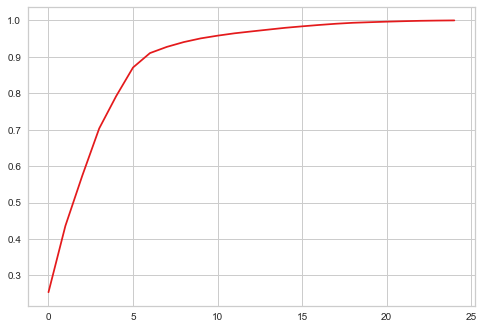

In [219]:
# show elbow plot

pca=PCA()
pca.fit(data_train_temp)
cumsum = np.cumsum(pca.explained_variance_ratio_)
pcaplot=sns.lineplot(data=cumsum)
pcaplot.grid(True)
# pcaplot.axis([0, 16, 0, 1.1]);

>Note: the number of clusters is the x axis

Based on the elbow method, I conclude that 6 features are enough to carry information.

In [220]:
print('Jumlah informasi yang dibawa adalah ', cumsum[5]*100,'%')

Jumlah informasi yang dibawa adalah  87.07275295647112 %


5 features do not carry 80% of the information from the train data.

**Conclusion**

Based on VIF and Elbow, it was decided that the number of features after reduction was 6 considering that the number of features with a value of 6 could already bring more than 80% and there would be no significant change if there were more than 6 features.
>Note: Feature number 5 only carries 79% of the data

In [221]:
# Reduksi feature menjadi 6
pca = PCA(n_components=6)
final_pipe_preprocessing=Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca',pca)
])
data_train_final=final_pipe_preprocessing.fit_transform(data_train)

#make data visual pca 2d
data_visual_train=PCA(n_components=2).fit_transform(data_train_temp)

# Clustering

Clustering is carried out using 4 methods, namely the **K-Means, Spectral, DB Scan** and **Aglomeratove** methods

## K-Means

### Chosing n-cluster

Before doing Clustering, we first need to analyze the optimal number of clusters. The exact number of clusters is analyzed in 2 ways, namely `elbow method` and `shilouette Visualization`. Our Elbow method uses 2 matrices, namely `shiloutte` and `distortion.` The distortion score focuses on the distance between the data and the centroid. Meanwhile, the silhouette score considers the distance between data and its centroid, data with other nearby centoids, and between centroids and other centroids.

**Elbow Methode**

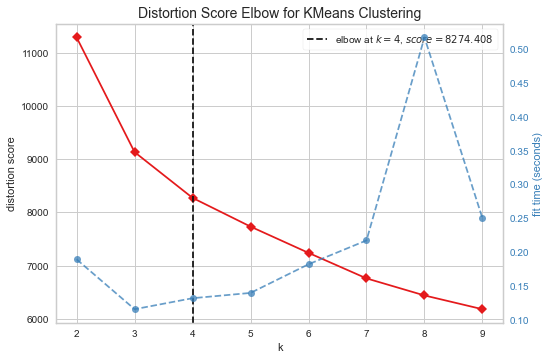

In [222]:
# Show ELbow distortion Plot 

Elbow_M = KElbowVisualizer(KMeans(), k=9)
Elbow_M.fit(data_train_final)
Elbow_M.show();

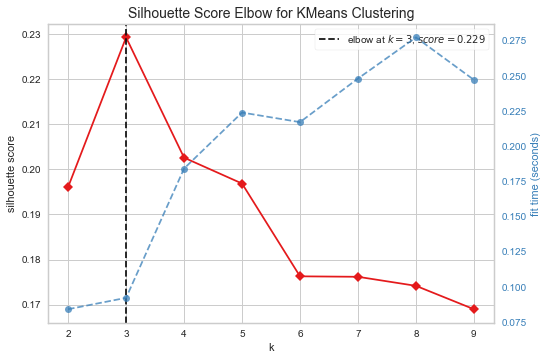

In [223]:
# Show ELbow Shilouette Plot

Elbow_M = KElbowVisualizer(KMeans(), k=9, metric='silhouette')
Elbow_M.fit(data_train_final)
Elbow_M.show();

The elbow above provides different recommendation results. Elbow with distortion metrics provides a recommendation of **4 clusters**. Meanwhile, based on the silhouette score, elbow recommends **3 clusters**. So that we can choose in more detail, we can use silhouette visualization to reconsider the number of clusters.

**Silhouette Visualizatiom**

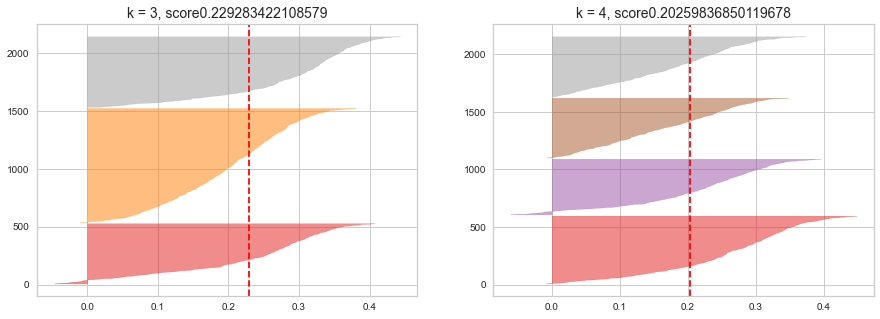

In [224]:
# menampilkan plot siluet
i=0
j=0
fig, ax=plt.subplots(1,2, figsize=[15,5])
fig.subplots_adjust( wspace=0.2, hspace=0.1)
for k in [3,4]:
    visualizer = SilhouetteVisualizer(KMeans(n_clusters=k, random_state=26), ax=ax[i])
    visualizer.fit(data_train_final)
    visualizer.set_title("k = "+ str(k) + ', score'+ str(visualizer.silhouette_score_))
    i=i+1

If you look at the 2 silhouette visualizations above, clusters 3 and 4 are equally good. However, I decided to choose 3 clusters for the reason that companies that use the results of this clustering can simply create 3 different programs or promos for each cluster. It is hoped that a smaller number of programs or promos will save time in making them and be more effective.

### Model Definition, Train & Predict

Based on the elbow results and silhouette score evaluation, cluster number 2 is the most optimal cluster.

In [225]:
# model definition
km_clust=KMeans(n_clusters=3, random_state=26)

#train model
km_clust.fit(data_train_final)

#predict
clust_km=km_clust.predict(data_train_final)

### Plotting

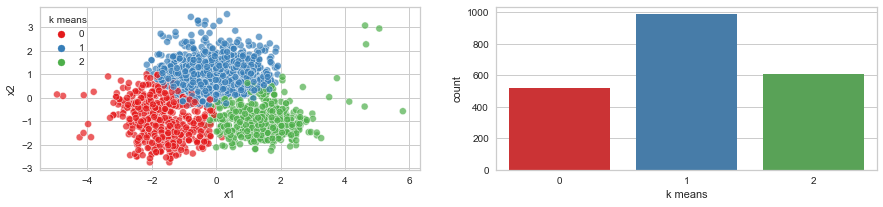

In [226]:
# set palet color
sns.set_palette('Set1')

# save clustering result
data_train['k means']=clust_km

#visualisasi clustering in 2 dimention
data_train_visual=pd.DataFrame(data=data_visual_train, columns=['x1', 'x2'])
data_train_visual['k means']=clust_km

# Plotting  hasil predict in 2d
fig, ax=plt.subplots(1,2, figsize=[15,3])
sns.scatterplot(data=data_train_visual, x='x1', y='x2', hue='k means', alpha=0.7, palette='Set1', ax=ax[0])
sns.countplot(data=data_train_visual, x='k means', ax=ax[1]);

The data was successfully clustered/segmented into 3 clusters. Kmeans succeeded in clustering well because the distribution shape matched the k means model. If we look at the data visualized in 2 dimensions, there are 3 pieces of data gathered to form a circle. K means is very good at recognizing these patterns.

Cluster number 1 is the most dominant cluster.

## Spectral

The second model used is Spectral. The number of clusters used in this second model is the same as in k means,  3.

### Model Definition

<AxesSubplot:xlabel='spectral', ylabel='count'>

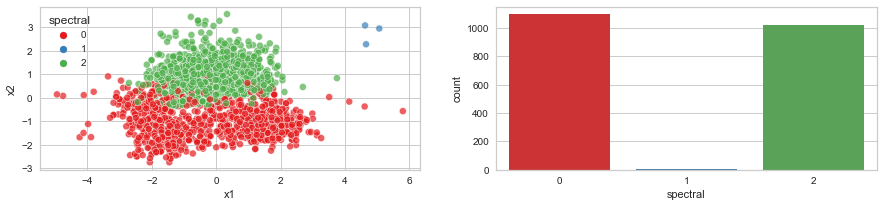

In [48]:
#Model Definition
spectral=SpectralClustering(n_clusters=3, random_state=26)   
     
#predict & save predict result
data_train_visual['spectral']=data_train['spectral']=spectral.fit_predict(data_train_final)

# Plotting
fig, ax=plt.subplots(1,2, figsize=[15,3])
sns.scatterplot(data=data_train_visual, x='x1', y='x2', hue='spectral', alpha=0.7, palette='Set1', ax=ax[0])
sns.countplot(data=data_train_visual, x='spectral', ax=ax[1])

> Spectral Model Produces 3 clusters. However, cluster 1 only got 3 pieces of data. while clusters 0 and 3 perform best well. The clustering carried out by spectral on this data did not produce good clusters.

## DB Scan

The third model used is DB scan. The DB Scan model is different from other models. We cannot determine from the start how many clusters will be created. What can be done at the beginning is to determine the epsilon value and minimum sample. After determining these two values, the model works and determines the results of the number of clusters and outliers.

Because of this, I did 25x experiments with different combinations of epsilon and minimum sample values. Then the best combination is chosen, namely the combination that produces the best clustering plot with minimal ouliers.

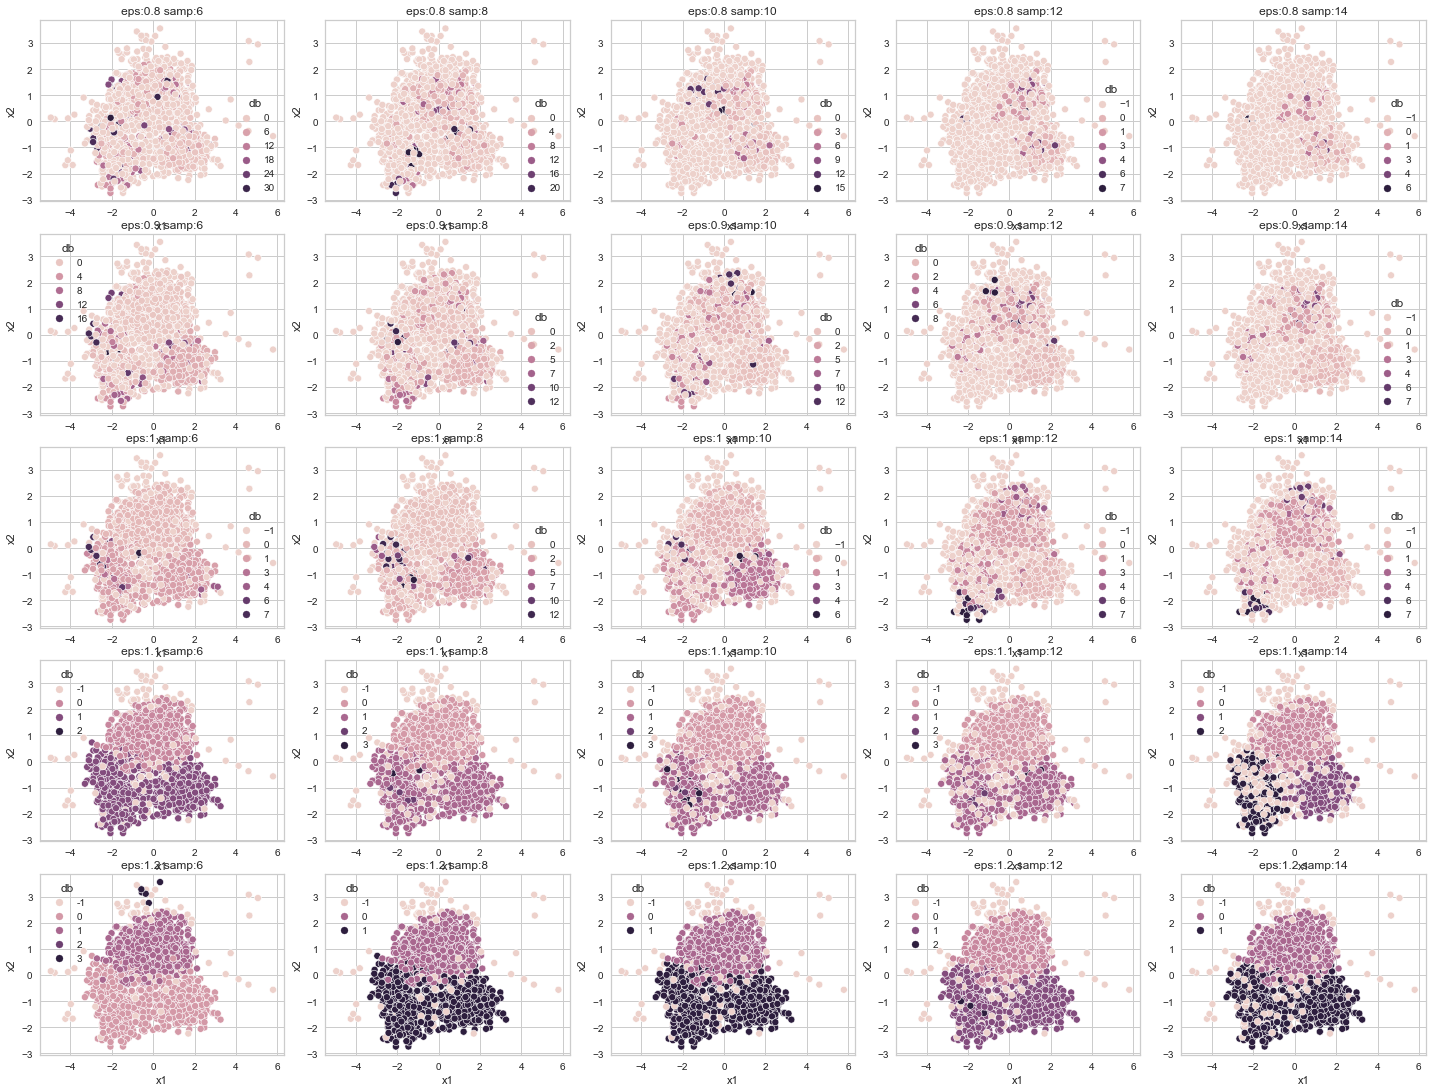

In [49]:
fig, ax=plt.subplots(5,5, figsize=[20, 15])
fig.tight_layout()
eps=[.8,.9,1,1.1,1.2]
sample=[6,8,10,12,14]
i=0
for ep in eps:
    j=0
    for sam in sample:
        db=DBSCAN(eps=ep, min_samples=sam)
        data_train_visual['db']=data_train['db']=db.fit_predict(data_train_final)
        visual=sns.scatterplot(data=data_train_visual, x='x1', y='x2', hue='db', ax=ax[i][j])
        visual.set_title('eps:'+str(ep)+' samp:'+str(sam))
        j=j+1
    i=i+1

Based on the plot above, I chose the cluster results with the last 2 row columns with the combination `eps=1.2` and `minimum sample =8`

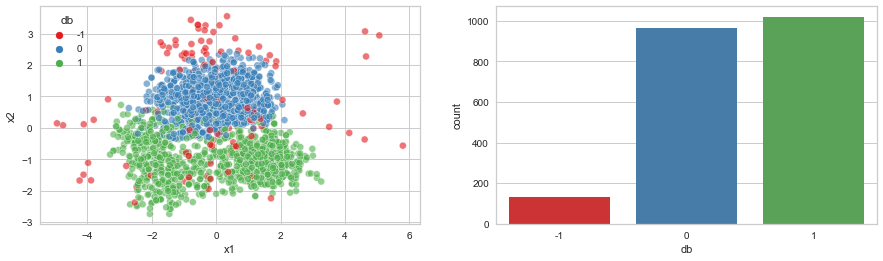

In [50]:
# model definition
db=DBSCAN(eps=1.2, min_samples=8)

# pedict & save  predict result
data_train_visual['db']=data_train['db']=db.fit_predict(data_train_final)

#plotting
fig, ax=plt.subplots(1,2, figsize=[15, 4])
scatter=sns.scatterplot(data=data_train_visual, x='x1', y='x2', hue='db', palette='Set1', alpha=.6, ax=ax[0])
sns.countplot(data=data_train_visual, x='db', ax=ax[1]);

The DB Scan model succeeded in clustering into 2 clusters and outliers. The data is divided into 2 well. It's just that if we pay attention, there are still many outliers located in the middle of the cluster.

## Aglomeratif Clustering

### Coosing n-cluster

Agglomerative Clustering is one of the hierarchical clustering. To help determine the optimal number of clusters, we can examine the dendogram results.
To create dendogram data and determine the optimal number of clusters, I used the clusteval library. (source [here](https://pypi.org/project/clusteval/2.0.4/))


[clusteval] >Fit using agglomerative with metric: euclidean, and linkage: ward
[clusteval] >Evaluate using silhouette.


100%|██████████| 23/23 [00:04<00:00,  4.65it/s]


[clusteval] >Compute dendrogram threshold.
[clusteval] >Optimal number clusters detected: [3].
[clusteval] >Fin.
[clusteval] >Plotting the dendrogram with optimized settings: metric=euclidean, linkage=ward, max_d=52.269. Be patient now..
[clusteval] >Compute cluster labels.


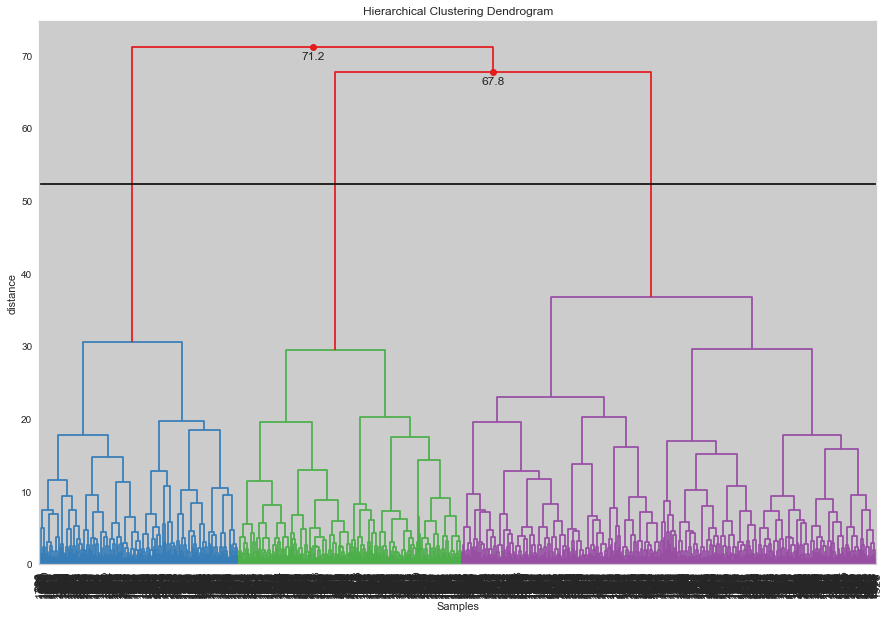

In [51]:
ce = clusteval(linkage='ward')
ce.fit(data_train_final)
ce.dendrogram();

The dendogram results show that the optimal number of clusters is 2 with the maximum distance between each cluster not being much different (seen from the first branch in each cluster).

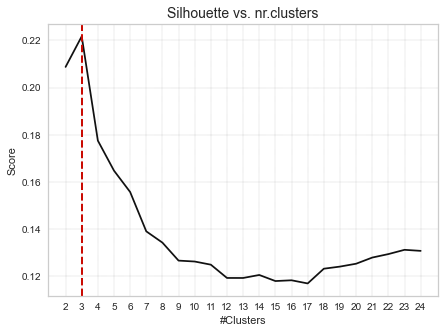

In [52]:
# skor siluet setiap cluster
ce.plot(figsize=(7,5));

Based on the silhouette score we can determine that agglomerative will be optimal on `3 clusters`.

[clusteval] >Estimated number of n_clusters: 3, average silhouette_score=0.222


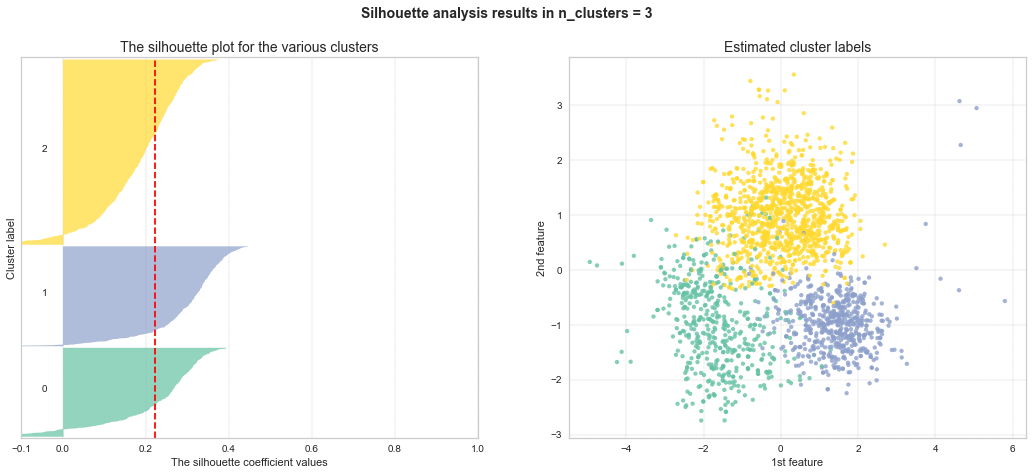

In [53]:
# siluet plot dan scatter plot clustering
ce.scatter(data_train_final, figsize=(20, 4));

Above is a silhouette score plot and visualization results in 2-dimensional form. If you look at the silhouette plot results, all clusters are cut off by the red line which is the average silhouette score. In this case, I conclude that clusteval has succeeded in determining the most optimal number of clusters and the value is 3.

### Predict & Ploting

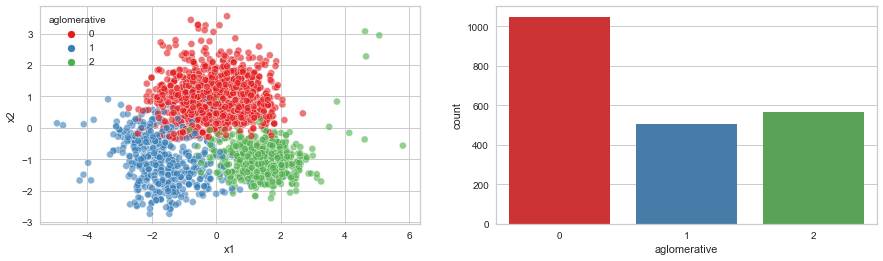

In [54]:
# plotting manual
aglo=AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage='ward')
data_train_visual['aglomerative']=data_train['aglomerative'] = aglo.fit_predict(data_train_final)
fig, ax=plt.subplots(1,2, figsize=[15, 4])
scatter=sns.scatterplot(data=data_train_visual, x='x1', y='x2', hue='aglomerative', alpha=.6, palette="Set1", ax=ax[0]);
count=sns.countplot(data=data_train_visual, x = 'aglomerative', ax=ax[1])

Model Aglomerative berhasil melakukan clustering dengan baik. Namun masih terdapat data yang merupakan cluster lain tereletak di tengah-tengah cluster 1. Jumlah cluster 0 mejadi cluster paling dominan.

Based on the results of clustering the 4 models, I decided the k means model as the best model for further use in the system.

**save model**

In [55]:
# make final pipline
final_pipe=Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca',pca),
    ('kmeans', KMeans(n_clusters=3, random_state=26))
])

In [56]:
final_pipe.fit(data_train)
f = open("finalpipe.pkl", "wb")
pickle.dump(final_pipe, f)
f.close()

## Inferencing

**Membuat data visual 2 dimensi untuk data inference**

In [57]:
# membuat data 2 dimennsi dengan pca
data_inf_2d=PCA(n_components=2).fit_transform(preprocessor.transform(data_inf))
data_inf_visual=pd.DataFrame(data=data_inf_2d, columns=['x1', 'x2'])

**Preprocessing Data Inference**

In [58]:
#preprocessing data inference
data_inf_final=final_pipe_preprocessing.transform(data_inf)

In [59]:
#prediksi dan menyimpan hasil prediksi pada data visual dan data inference asli
data_inf_visual['k means']=data_inf['k means']=km_clust.predict(data_inf_final)
data_inf['spectral']=data_inf_visual['spectral']=spectral.fit_predict(data_inf_final)
data_inf['aglomerative']=data_inf_visual['aglomerative']=aglo.fit_predict(data_inf_final)
data_inf['db']=data_inf_visual['db']=db.fit_predict(data_inf_final)

In [60]:
data_inf.columns[-4:]

Index(['k means', 'spectral', 'aglomerative', 'db'], dtype='object')

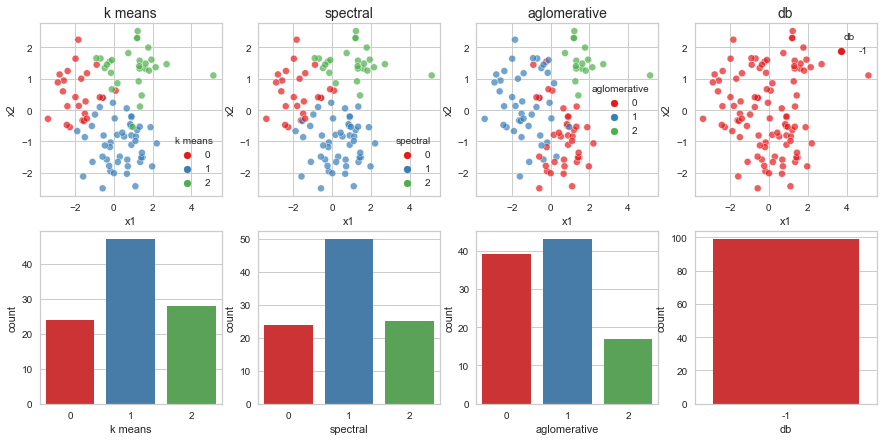

In [61]:
#plotting hasil prediksi
fig,ax=plt.subplots(2,4, figsize=[15,7])
i=0
for col in data_inf.columns[-4:]:
    visual_scatter=sns.scatterplot(data=data_inf_visual, x='x1', y='x2', hue=col, alpha=.7, palette='Set1', ax=ax[0][i])
    visual_scatter.set_title(col)
    visual_count=sns.countplot(data=data_inf_visual, x=col, ax=ax[1][i])
    i=i+1

# Analysis Clutering

In this section I want to look again at the clustering results and how the model separates data based on the cluster results.

To make it easier to carry out analysis, I separated the features based on their correlation values. The clustering results analyzed in this section are the results of k-means clustering which are the best results so far.

**informasi Personal**

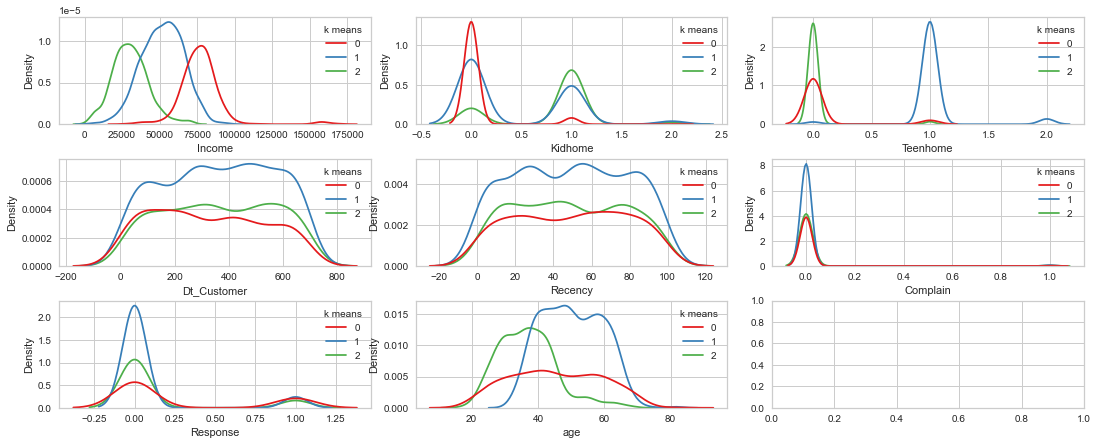

In [62]:
people=['Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'Complain', 'Response', 'age']
wahyu_lib.show_kde(data=data_train, list=people, hue='k means')

**Cluster 0** is the cluster with the highest income. **Cluster 0** also rarely has small children or teenagers. The average age of **cluster 0** spreads from 20 years old to 75 years old. **cluster 1** are consumers who mostly have teenage children and have middle income. Because they already have teenage children, it is natural that the majority of **cluster 1** are aged from 40 to 75 years old. Cluster 2 is a cluster that has low income and most of them are aged 20 to 40 years. Some from cluster 2 also have young children. The program for cluster 2 can use products for the needs of young children.

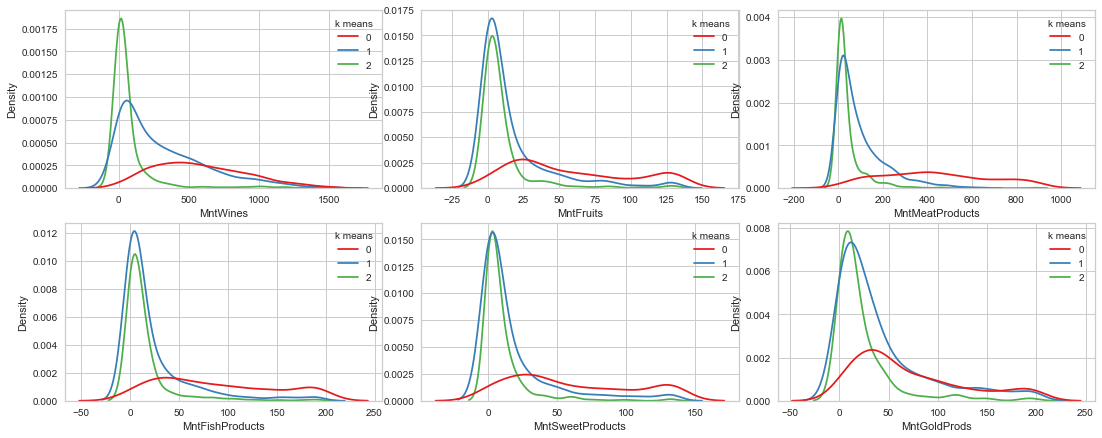

In [63]:
produk=['MntWines', 'MntFruits', 'MntMeatProducts','MntFishProducts', 'MntSweetProducts', 'MntGoldProds',]
wahyu_lib.show_kde(data=data_train, list=produk, hue='k means')

All types of products have the same pattern in purchasing clusters. As previously stated, **cluster 1** is the cluster that has the most income, therefore it is natural that **cluster 0** is the cluster that makes the most purchases of all types of products, followed by **cluster 1** and * *cluster 2** as the cluster that makes the fewest purchases. However, for gold products, **cluster 1** made almost the same purchases as **cluster 0**.

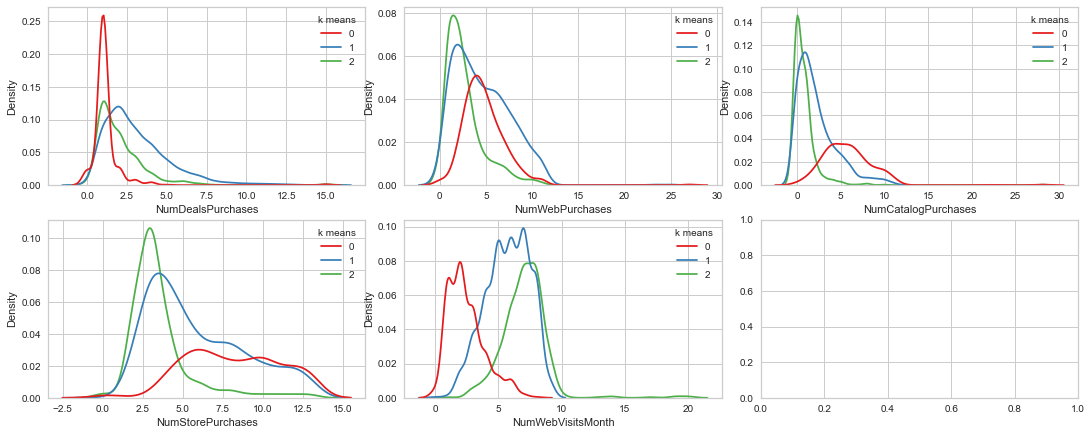

In [64]:
purchase=['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases','NumStorePurchases', 'NumWebVisitsMonth']
wahyu_lib.show_kde(data=data_train, list=purchase, hue='k means')

Based on the plot above, we can see that ****cluster 0**** are customers who very rarely make purchases due to the discount program (`num dealas purchases`) and more often make purchases through direct stores or catalogs. **cluster 0** also rarely views company websites. I suggest that the company focus more on promotions through catalogs for **cluster 0** and make good arrangements so that **cluster 0** increases its shopping amount because **cluster 0** is the customer with the largest income.

Meanwhile **cluster 1** is the cluster that makes the most purchases because of discounts and quite often views the company website. Discounts will be more effective if we distribute them frequently via the website. **Cluster 2** is a cluster that rarely spends on all platforms.

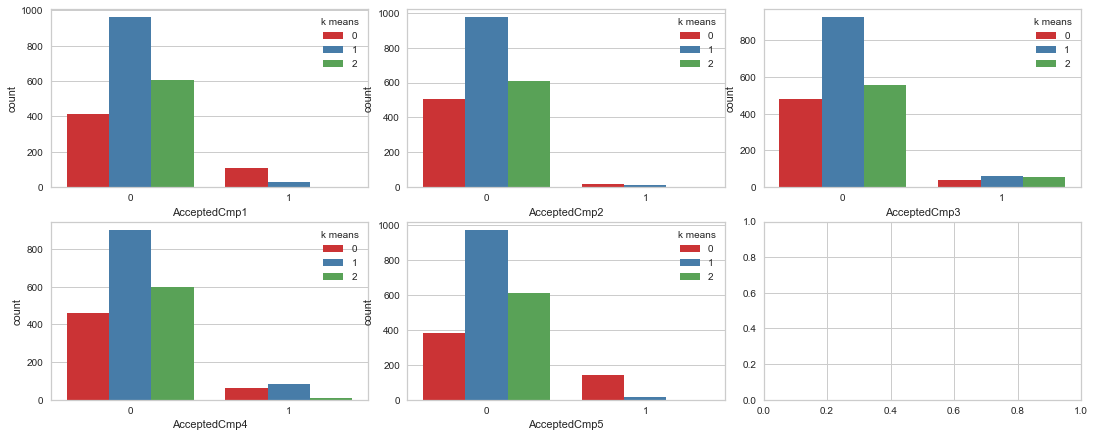

In [65]:
promo=['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']
wahyu_lib.show_count(data=data_train, list=promo, hue='k means')

Most consumers do not approve of the promotions we offer, I suggest companies continue to improve their promotions and programs so that they are more accepted by consumers.

However, if we only focus on accepting offers, most of those who accepted our offer came from cluster 0 and cluster 1. Cluster 0 received more company promotional offers on the `first` and `5th` offers. while cluster 1 mostly agrees with our offers on offers `3` and `4`. Meanwhile, cluster 2 only accepted the 3rd offer.

Even though very few agreed to the second offer, I suggest that the company and marketing team remain active in making subsequent offers because if you look at the data there is an increase in promotional acceptance for the 3rd offer and so on.

<AxesSubplot:xlabel='k means', ylabel='count'>

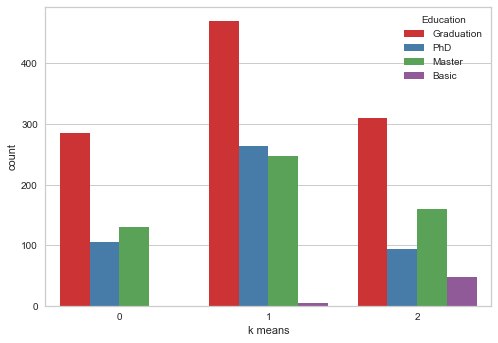

In [66]:
sns.countplot(data=data_train, hue='Education', x= 'k means')

Education levels from graduation to PhD are spread evenly across all clusters, while consumers with basic education are mostly in cluster 2.

# Kesimpulan

The best model used is kmeans. The model successfully clustered into 3 clusters with the details below:

**Cluster 0:**
- the customer cluster that has the most revenue.
- Because it has the largest income, cluster 0 also makes the most transactions ranging from wine, fruit, meat, fish, gold and *sweets* products.
- most do not have small children at home.
- purchases made by cluster 0 are mostly through catalogs and coming directly to the shop. even though you rarely see the website, cluster 0 is the cluster that most often makes purchases via the website.
- The age of cluster 0 is evenly distributed, starting from 20 years of age to approaching 80 years of age.
- Purchases of goods are not influenced by discounts (`num deals purchase`)

**Cluster 1:**
- customers with middle income
- with medium income, cluster 1 does not buy too many various products (wine, fruit, meat, fish, gold and *sweets*) but slightly more than cluster 2
- have Most do not have children, but some have 1 child and only a small number have 2 children. Most of cluster 1 has teenage children.
- Cluster 1 is customers with most ages over 35 years.
- Cluster 1 makes more purchasing decisions through discounts (`num deals purchase`)

**Cluster 2:**
- Customers with low income
- Are customers who make purchases the least frequently.
- Customer age ranges from 20 to 40 years old
- Most have small children at home.


Based on the characters above, I changed the cluster name to
- cluster 0 : **Priority Customer**
- cluster 1 : **Potential Customers**
- cluster 2 : **Regular Customers**

Based on the results of the analysis and EDA, I also provide recommendations for marketing to carry out promotions to priority customers in the form of offline, catalogs or displays in stores. Products that can be used are meat and wine. Priority customers are also not customers who are reactive to discounts. So marketing needs to look for other ways to make promotions successful. I recommend promotions in the form of discounts delivered via the website to be targeted at potential customers. Potential customers are customers who have small children and teenagers. Marketing can use this information to develop marketing programs targeted at potential customers.